In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from fipy import numerix as nmx

In [303]:
from scipy import fftpack

In [554]:
nx = 1024

In [555]:
Lx = 15.

In [556]:
mesh = fp.Grid2D(nx=nx, ny=nx, Lx=Lx, Ly=Lx)

In [557]:
dX = fp.CellVariable(mesh=mesh, name=r"$\delta X$")

In [ ]:
0.947 - 0.053

In [558]:
dX.setValue(1., where=(mesh.x - Lx / 2.)**2 + (mesh.y - Lx / 2.)**2 <= 1.4**2)

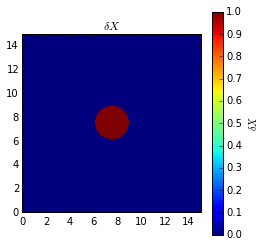

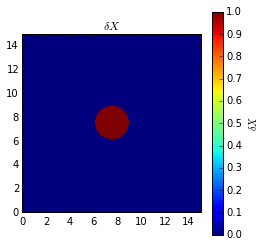

In [559]:
fp.Viewer(vars=dX)

## reciprocal lattice vector

In [560]:
g = fp.CellVariable(mesh=mesh, name=r"$\vec{g}$", rank=1)

In [561]:
g.value.shape = (-1, g.mesh.nx, g.mesh.nx)

In [562]:
g.value[0] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)

In [563]:
g.value[1] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)[..., nmx.newaxis]

In [564]:
g.value.shape = (-1, g.mesh.numberOfCells)

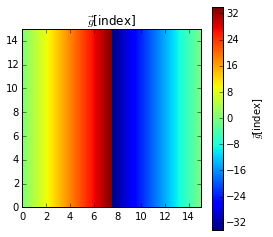

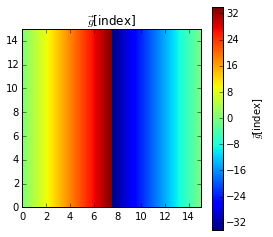

In [565]:
fp.Viewer(vars=g[0])

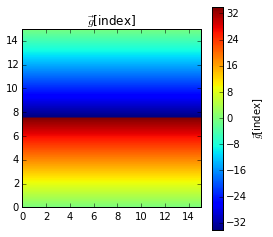

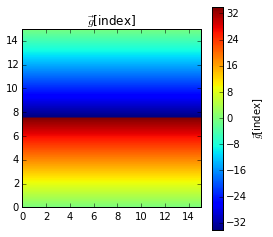

In [566]:
fp.Viewer(vars=g[1])

In [567]:
C11 = 280e9
C12 = 120e9
C44 = (C11 - C12)/2.

$C_{11} = C_{22} \rightarrow C_{1111} = C_{2222}$

$C_{12} = C_{21} \rightarrow C_{1122} = C_{2211}$

$C_{44} = C_{55} = C_{66} \rightarrow C_{1212} = C_{1221} = C_{2112} = C_{2121} $

In [568]:
C = nmx.zeros((2, 2, 2, 2))

In [569]:
C[0][0][0][0] = C[1][1][1][1] = C11
C[0][0][1][1] = C[1][1][0][0] = C12
C[0][1][0][1] = C[0][1][1][0] = C[1][0][0][1] = C[1][0][1][0] = C44

In [570]:
Gik_inv = nmx.einsum('ijkl,j...,l...->ik...', C, g.value, g.value)

In [571]:
Gik_inv[..., 0] = [[1., 0.],
                   [0., 1.]]

In [572]:
Gik = nmx.rollaxis(nmx.array(map(nmx.linalg.inv, nmx.rollaxis(Gik_inv, axis=2))), axis=0, start=3) 

In [573]:
epsilon0 = 0.01

In [574]:
eigenstrain = epsilon0 * nmx.eye(2,2)

In [575]:
eigenstress = nmx.einsum('ijkl...,kl...->ij...', C, eigenstrain)

In [576]:
dXg = fftpack.fftn(dX.value.reshape((nx, nx))).reshape(-1)

In [577]:
ug = -1j * nmx.einsum('ik...,j...,ij...->k...', Gik, g, eigenstress) * dXg

In [579]:
straing = 0.5j * (nmx.einsum('i...,j...->ij...', ug, g) + nmx.einsum('j...,i...->ij...', ug, g))

In [580]:
strain = fftpack.ifftn(straing.reshape((2, 2, nx,nx)), axes=(2,3)).reshape((2, 2, -1))

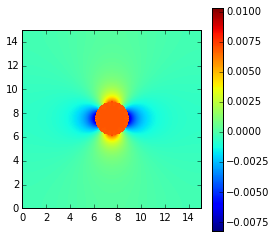

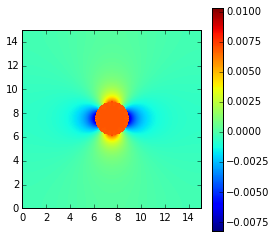

In [582]:
fp.Viewer(vars=fp.CellVariable(mesh=mesh, value=strain[0][0].real))

In [583]:
stress = nmx.einsum('ijkl...,kl...->ij...', C, strain - eigenstrain[..., nmx.newaxis] * dX.value)

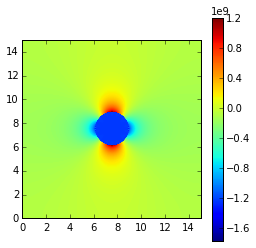

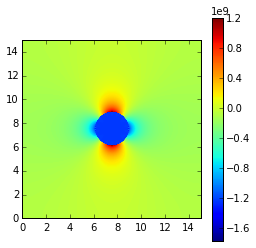

In [584]:
fp.Viewer(vars=fp.CellVariable(mesh=mesh, value=stress[0][0].real))

In [585]:
mesh1D = fp.Grid1D(nx=mesh.nx, Lx=Lx)

In [588]:
halfx = mesh.x[nx//2]

ValueError: setting an array element with a sequence.

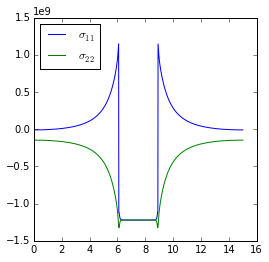

In [589]:
fp.Viewer(vars=(fp.CellVariable(mesh=mesh1D, name=r"$\sigma_{11}$", value=stress[0][0][(mesh.x == halfx).value]),
                fp.CellVariable(mesh=mesh1D, name=r"$\sigma_{22}$", value=stress[1][1][(mesh.x == halfx).value])))

ValueError: setting an array element with a sequence.

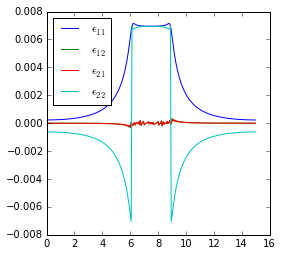

In [553]:
fp.Viewer(vars=(fp.CellVariable(mesh=mesh1D, name=r"$\epsilon_{11}$", value=strain[0][0][(mesh.x == halfx).value]),
                fp.CellVariable(mesh=mesh1D, name=r"$\epsilon_{12}$", value=strain[0][1][(mesh.x == halfx).value]),
                fp.CellVariable(mesh=mesh1D, name=r"$\epsilon_{21}$", value=strain[1][0][(mesh.x == halfx).value]),
                fp.CellVariable(mesh=mesh1D, name=r"$\epsilon_{22}$", value=strain[1][1][(mesh.x == halfx).value])))

In [550]:
strain0 = strain.copy()

In [551]:
stress0 = stress.copy()

In [ ]:
ug = -1j * nmx.einsum('ik...,j...,ij...->k...', Gik, g, eigenstress) * dXg